# Example: Compute the Probability of Profit for a Single Options Contract
Fill me in

## Setup
Set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions we will use in the exercise, and custom types to model the components of our example problem.
* For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl). 

In [3]:
include("Include.jl");

    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
   Resolving package versions...
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-134/module-2/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-134/module-2/Manifest.toml`
  Activating project at `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-134/module-2`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-134/module-2/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-134/module-2/Manifest.toml`
    Updating registry at `~/.julia/registries/General.toml`
    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-134/module-2/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CH

## Prerequisites
Before doing anything else, load the options chain dataset using the `MyOptionsChainDataSet()` function. This function returns the pricing data as a [Julia Dictionary type](https://docs.julialang.org/en/v1/base/collections/#Dictionaries) with `keys` holding the number of days to expiration `DTE::Int64` and `values` being a [Vector](https://docs.julialang.org/en/v1/base/arrays/#Base.Vector-Tuple{UndefInitializer,%20Any}) of multilevel dictionaries. We'll store the options contract price data in the `dataset` variable.
* In this example, we'll use options pricing data for [Tesla](https://finance.yahoo.com/quote/TSLA/) as the underlying asset. The `dataset` variable holds pricing information for `call` and `put` contracts. Each contract has a different strike price. In addition to the contract price, there is additional information about the underlying asset and contract. 
* For any given `DTE` key, the price data is organized as a `Vector{Dict{String, Any}},` where each element in the vector corresponds to a different strike price, and each strike price is a dictionary with keys: `day,` `details,` `last_quote,` `last_trade,` `underlying_asset,` `open_interest` and `break_even_price.` Each key (except for the `open_interest` and `break_even_price` keys) points to another dictionary.

In [5]:
dataset = MyOptionsChainDataSet()

Dict{Int64, Vector{Dict{String, Any}}} with 17 entries:
  123 => [Dict("day"=>Dict{String, Any}(), "details"=>Dict{String, Any}("contra…
  60  => [Dict("day"=>Dict{String, Any}(), "details"=>Dict{String, Any}("contra…
  32  => [Dict("day"=>Dict{String, Any}("change"=>0, "high"=>240.85, "change_pe…
  11  => [Dict("day"=>Dict{String, Any}("change"=>0, "high"=>144.01, "change_pe…
  368 => [Dict("day"=>Dict{String, Any}("change"=>0, "high"=>513.88, "change_pe…
  578 => [Dict("day"=>Dict{String, Any}("change"=>0, "high"=>350.37, "change_pe…
  214 => [Dict("day"=>Dict{String, Any}("change"=>0, "high"=>627.95, "change_pe…
  270 => [Dict("day"=>Dict{String, Any}("change"=>0, "high"=>341.78, "change_pe…
  459 => [Dict("day"=>Dict{String, Any}("change"=>0, "high"=>244.4, "change_per…
  39  => [Dict("day"=>Dict{String, Any}(), "details"=>Dict{String, Any}("contra…
  732 => [Dict("day"=>Dict{String, Any}("change"=>0, "high"=>246.45, "change_pe…
  914 => [Dict("day"=>Dict{String, Any}("change"=>0, 

In [77]:
dataset[60][50]

Dict{String, Any} with 9 entries:
  "day"                => Dict{String, Any}("change"=>0, "high"=>6.7, "change_p…
  "details"            => Dict{String, Any}("contract_type"=>"put", "ticker"=>"…
  "last_quote"         => Dict{String, Any}("midpoint"=>6.125, "ask"=>6.2, "tim…
  "last_trade"         => Dict{String, Any}("timeframe"=>"REAL-TIME", "exchange…
  "underlying_asset"   => Dict{String, Any}("timeframe"=>"REAL-TIME", "ticker"=…
  "greeks"             => Dict{String, Any}("theta"=>-0.126845, "gamma"=>0.0036…
  "open_interest"      => 3898
  "implied_volatility" => 0.627397
  "break_even_price"   => 203.875

In [7]:
list_of_options_chains = Dict{Int64,DataFrame}();
DTEs = keys(dataset) |> collect |> sort;
for dte_value ∈ DTEs

    dataframe = search(dataset, dte_value, (DTE::Int64, record::Dict{String, Any}) -> begin

            # initialize -
            should_keep_record = false;

            # what is the strike?
            K = record["details"]["strike_price"];
            if (record["details"]["contract_type"] == "put" && 60.0 ≤ K ≤ 800.0)
                should_keep_record = true
            end;
            
            # return -
            return should_keep_record;
        end
    );
    list_of_options_chains[dte_value] = dataframe;
end

In [8]:
list_of_options_contracts = list_of_options_chains[60]

Row,underlying,strike,type,IV,bid,ask,midpoint,break_even_price,bid_size,ask_size
,Float64,Float64,String,Float64,Float64,Float64,Float64,Float64,Int64,Int64
1,261.49,500.0,put,0.927699,237.1,241.3,239.2,260.8,1,5
2,261.49,490.0,put,0.905908,227.1,231.35,229.225,260.775,5,5
3,261.49,480.0,put,0.883666,217.15,221.35,219.25,260.75,1,5
4,261.49,470.0,put,0.870004,207.15,211.6,209.375,260.625,5,5
5,261.49,460.0,put,0.859859,198.45,200.65,199.55,260.45,28,16
6,261.49,450.0,put,0.855444,188.7,190.9,189.8,260.2,28,12
7,261.49,440.0,put,0.818092,178.5,180.85,179.675,260.325,28,12
8,261.49,430.0,put,0.822331,168.95,171.15,170.05,259.95,28,12
9,261.49,420.0,put,0.804237,159.25,161.15,160.2,259.8,3,3


Parameters

In [10]:
Δt = (1.0/252.0);
Sₒ = 261.49;

## Task 1: Compute the break-even points for short TSLA puts
Suppose you sold a `DTE = 60-day` put option on `TSLA,` and you collected the mid-point premium for the sale. Let's use options data in the `dataset` to compute the breakeven point for the contract, i.e., the value of the `TSLA` share price where you start to lose money on the trade as a function of the strike price `K.`

In [12]:
contractmodel = build(MyAmericanPutContractModel, (
    K = 0.0,
    premium = 0.0
));

In [56]:
number_of_contracts = nrow(list_of_options_contracts);
for i ∈ 1:number_of_contracts

    contractmodel.K = list_of_options_contracts[i, :strike]
    contractmodel.premium = list_of_options_contracts[i,:midpoint]
    breakeven_computed = contractmodel.K - contractmodel.premium
    @show (breakeven_computed,list_of_options_contracts[i, :break_even_price])
    
end

(breakeven_computed, list_of_options_contracts[i, :break_even_price]) = (260.8, 260.8)
(breakeven_computed, list_of_options_contracts[i, :break_even_price]) = (260.775, 260.775)
(breakeven_computed, list_of_options_contracts[i, :break_even_price]) = (260.75, 260.75)
(breakeven_computed, list_of_options_contracts[i, :break_even_price]) = (260.625, 260.625)
(breakeven_computed, list_of_options_contracts[i, :break_even_price]) = (260.45, 260.45)
(breakeven_computed, list_of_options_contracts[i, :break_even_price]) = (260.2, 260.2)
(breakeven_computed, list_of_options_contracts[i, :break_even_price]) = (260.325, 260.325)
(breakeven_computed, list_of_options_contracts[i, :break_even_price]) = (259.95, 259.95)
(breakeven_computed, list_of_options_contracts[i, :break_even_price]) = (259.8, 259.8)
(breakeven_computed, list_of_options_contracts[i, :break_even_price]) = (259.6, 259.6)
(breakeven_computed, list_of_options_contracts[i, :break_even_price]) = (259.45, 259.45)
(breakeven_computed, li

## Task 2: Construct a single asset geometric Brownian motion of TSLA share price
Fill me in

In [15]:
parameters_df = CSV.read(joinpath(_PATH_TO_DATA, "gbmparameters", "Parameters-SP500-2018-2023.csv"), DataFrame)

Row,ticker,drift,volatility
,String7,Float64,Float64
1,A,0.151876,0.183345
2,AAL,-0.207376,0.353988
3,AAP,-0.0458017,0.221122
4,AAPL,0.291789,0.262843
5,ABBV,0.118954,0.170957
6,ABT,0.104121,0.157652
7,ACN,0.145112,0.164483
8,ADBE,0.136256,0.216782
9,ADI,0.13822,0.280011


Construct gbm

In [17]:
model = build(MyGeometricBrownianMotionEquityModel, (
    μ = filter(:ticker=> x-> x=="TSLA", parameters_df)[!,:drift] |> first,
    σ = filter(:ticker=> x-> x=="TSLA", parameters_df)[!,:volatility] |> first
));

Sample

In [19]:
endpoint = VLQuantitativeFinancePackage.sample(model, (
    T₁ = 0.0,
    T₂ = (60.0)*(Δt),
    Δt = Δt,
    Sₒ = Sₒ
), number_of_paths = 5000) |> samples -> samples[end,2:end]; # get last row from col 2 -> number_of_paths

Unhide

In [21]:
d = fit_mle(LogNormal, endpoint)

LogNormal{Float64}(μ=5.669427164791117, σ=0.27276073185825445)

`Unhide` me

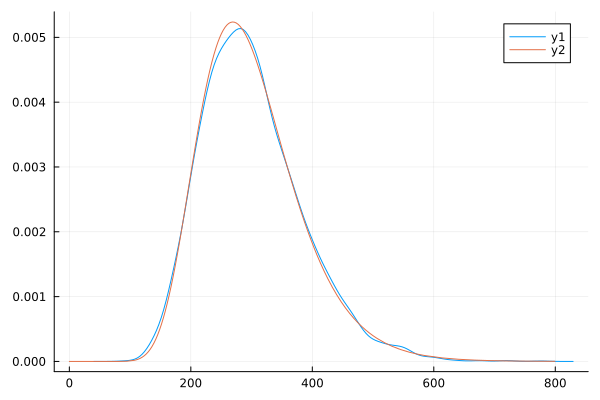

In [23]:
density(endpoint)
plot!(d)

In [24]:
cdf_model = cdf(d, sort(endpoint));

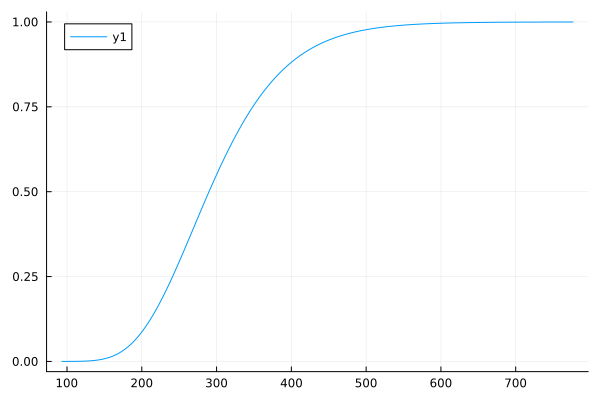

In [25]:
plot(sort(endpoint), cdf_model)

## Task 3: Estimate the probability of profit as a function of the strike price
Fill me in

In [81]:
for i ∈ 1:number_of_contracts
    K = list_of_options_contracts[i, :strike];
    P = list_of_options_contracts[i,:midpoint];
    ℬ = list_of_options_contracts[i, :break_even_price];
    @show i, K, Sₒ, P, ℬ, cdf(d,K), cdf(d,ℬ)
end

(i, K, Sₒ, P, ℬ, cdf(d, K), cdf(d, ℬ)) = (1, 500.0, 261.49, 239.2, 260.8, 0.9771823784384345, 0.3492221451414135)
(i, K, Sₒ, P, ℬ, cdf(d, K), cdf(d, ℬ)) = (2, 490.0, 261.49, 229.225, 260.775, 0.9728655505808065, 0.3490920805449537)
(i, K, Sₒ, P, ℬ, cdf(d, K), cdf(d, ℬ)) = (3, 480.0, 261.49, 219.25, 260.75, 0.9677775373377603, 0.34896202120607567)
(i, K, Sₒ, P, ℬ, cdf(d, K), cdf(d, ℬ)) = (4, 470.0, 261.49, 209.375, 260.625, 0.9617946609527293, 0.34831180394810396)
(i, K, Sₒ, P, ℬ, cdf(d, K), cdf(d, ℬ)) = (5, 460.0, 261.49, 199.55, 260.45, 0.9547776415336791, 0.34740172518861956)
(i, K, Sₒ, P, ℬ, cdf(d, K), cdf(d, ℬ)) = (6, 450.0, 261.49, 189.8, 260.2, 0.9465709140443801, 0.34610207905991575)
(i, K, Sₒ, P, ℬ, cdf(d, K), cdf(d, ℬ)) = (7, 440.0, 261.49, 179.675, 260.325, 0.9370023623463734, 0.3467518327183282)
(i, K, Sₒ, P, ℬ, cdf(d, K), cdf(d, ℬ)) = (8, 430.0, 261.49, 170.05, 259.95, 0.9258836440880582, 0.34480299638686907)
(i, K, Sₒ, P, ℬ, cdf(d, K), cdf(d, ℬ)) = (9, 420.0, 261.49, 160.2

## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. You should decide solely based on your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.